In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.std import tqdm
from collections import Counter

# For TF-IDF and topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

# For classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Set style for visualizations
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)


## 2. Load Data and Define Stopwords

In [40]:
# Basic set of English stopwords
BASIC_STOPWORDS = {
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
    'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'would', 
    'should', 'could', 'ought'
}

# Add North Carolina court-specific stopwords
NC_COURT_STOPWORDS = {
    'north', 'carolina', 'court', 'appeals', 'supreme', 'district', 'superior',
    'trial', 'appellate', 'courts', 'judicial', 'judge', 'judges', 'justice', 'justices',
    'opinion', 'dissent', 'concur', 'concurring', 'dissenting',
    'state', 'plaintiff', 'defendant', 'appellant', 'appellee', 'petitioner',
    'respondent', 'plaintiffs', 'defendants', 'appellants', 'appellees',
    'petitioners', 'respondents', 'versus', 'vs', 'dependant', 'dependants',
    'case', 'matter', 'docket', 'motion', 'brief', 'argument', 'hearing',
    'trial', 'verdict', 'judgment', 'order', 'petition', 'appeal', 'review',
    'affirm', 'affirmed', 'reverse', 'reversed', 'remand', 'remanded',
    'statute', 'statutory', 'code', 'section', 'subsection', 'paragraph',
    'rule', 'regulation', 'law', 'legal', 'illegal', 'lawful', 'unlawful'
}

# Add criminal procedure specific stopwords
CRIMINAL_STOPWORDS = {
    'arrest', 'arraignment', 'bail', 'bond', 'plea', 'plead', 'pleaded', 'pled',
    'guilty', 'not-guilty', 'nolo', 'contendere', 'trial', 'sentence', 'sentenced',
    'sentencing', 'conviction', 'convicted', 'acquit', 'acquitted', 'acquittal',
    'charge', 'charged', 'charging', 'indictment', 'indicted', 'warrant',
    'offense', 'offenses', 'crime', 'crimes', 'criminal', 'misdemeanor', 'felony',
    'probation', 'parole', 'suspended', 'imprisonment', 'incarceration'
}

# Combine all stopwords
COMBINED_STOPWORDS = BASIC_STOPWORDS.union(NC_COURT_STOPWORDS).union(CRIMINAL_STOPWORDS)

print(f"Total stopwords: {len(COMBINED_STOPWORDS)}")

# Load the JSON data
INPUT_FILE = "volume_cases/volume_cases.json"  # Update this path to your file
OUTPUT_DIR = "notebook_output"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    cases = json.load(f)

Total stopwords: 230


## 3. Examine and Preprocess the Data

In [ ]:
# Convert to DataFrame for easier manipulation
cases_df = pd.DataFrame(cases)

# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of cases: {len(cases_df)}")
print(f"Columns: {', '.join(cases_df.columns)}")

# Check for missing values
missing_text = cases_df['full_text'].isna().sum()
print(f"Cases missing full text: {missing_text} ({missing_text/len(cases_df)*100:.2f}%)")

# Look at a sample case
sample_case = cases_df.sample(1).iloc[0]
print("\nSample Case:")
print(f"Name: {sample_case.get('case_name', sample_case.get('name', 'Unknown'))}")
print(f"Citations: {sample_case.get('citations', 'Unknown')}")
print(f"Text length: {len(sample_case.get('full_text', '')) if isinstance(sample_case.get('full_text', ''), str) else 0} characters")

# Show first 300 characters of the text
if 'full_text' in sample_case and isinstance(sample_case['full_text'], str):
    print(f"\nText sample:\n{sample_case['full_text'][:300]}...")

# Simple tokenization function 
def simple_tokenize(text):
    """Simple word tokenization function"""
    if not text or not isinstance(text, str):
        return []
    # Remove punctuation and split by whitespace
    clean_text = ''.join(c.lower() if c.isalpha() or c.isspace() else ' ' for c in text)
    return [word for word in clean_text.split() if word]

# Preprocess all cases
print("\nPreprocessing cases...")
processed_cases = []

for i, case in tqdm(enumerate(cases), total=len(cases)):
    # Skip cases without full text
    if 'full_text' not in case or not case['full_text']:
        continue
    
    # Tokenize text
    full_text = case.get('full_text', '')
    tokens = simple_tokenize(full_text)
    
    # Filter out stopwords
    filtered_tokens = [token for token in tokens if token and token not in COMBINED_STOPWORDS]
    
    # Create processed case
    processed_case = {
        'case_id': i,
        'case_name': case.get('name', case.get('case_name', f"Case {i}")),
        'citations': case.get('citations', 'Unknown'),
        'full_text': full_text,
        'filtered_text': ' '.join(filtered_tokens),
        'total_tokens': len(tokens),
        'filtered_tokens': len(filtered_tokens),
        'volume': case.get('volume', 'Unknown')
    }
    
    processed_cases.append(processed_case)

# Convert to DataFrame
processed_df = pd.DataFrame(processed_cases)

print(f"Processed {len(processed_df)} cases with text")

# Analysis of token reduction
token_reduction = ((processed_df['total_tokens'] - processed_df['filtered_tokens']) / 
                  processed_df['total_tokens'] * 100)

print(f"\nToken Reduction Statistics:")
print(f"Average tokens before filtering: {processed_df['total_tokens'].mean():.2f}")
print(f"Average tokens after filtering: {processed_df['filtered_tokens'].mean():.2f}")
print(f"Average percentage of tokens removed: {token_reduction.mean():.2f}%")

# Visualize token reduction
plt.figure(figsize=(10, 6))
plt.hist(token_reduction, bins=20, alpha=0.7)
plt.title('Histogram of Token Reduction Percentage')
plt.xlabel('Percentage of Tokens Removed')
plt.ylabel('Number of Cases')
plt.axvline(token_reduction.mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(token_reduction.mean()+2, plt.ylim()[1]*0.9, f'Mean: {token_reduction.mean():.2f}%')
plt.tight_layout()
plt.show()


Dataset Information:
Number of cases: 602
Columns: volume, case_name, citations, first_page, last_page, full_text, pages_details, cleaned_text, sections
Cases missing full text: 0 (0.00%)

Sample Case:
Name: state of north carolina v. anna danielle crouse
Citations: 169 N.C. App. 382
Text length: 30078 characters

Text sample:
                                                         
                                                         
                                                         
                                                         
                                                         
         3...

Preprocessing cases...


100%|██████████| 602/602 [00:04<00:00, 126.61it/s]

Processed 602 cases with text

Token Reduction Statistics:
Average tokens before filtering: 3655.91
Average tokens after filtering: 2039.10
Average percentage of tokens removed: 44.34%


## 4. Feature Extraction with TF-IDF and Topic Modeling

In [ ]:
# TF-IDF Vectorization
print("Performing TF-IDF vectorization...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=3,  # Term must appear in at least 3 documents
    max_df=0.8,  # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['filtered_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Created TF-IDF matrix with shape: {tfidf_matrix.shape}")
print(f"Number of features (terms): {len(feature_names)}")

# Look at most common terms
def display_top_features(vectorizer, top_n=20):
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Get document frequency for each term
    df_counts = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
    
    # Create DataFrame with term and count
    df = pd.DataFrame({
        'term': feature_names,
        'count': df_counts
    })
    
    # Sort by count and display top N
    return df.sort_values('count', ascending=False).head(top_n)

top_terms = display_top_features(tfidf_vectorizer)
print("\nTop terms by document frequency:")
print(top_terms)

# Visualize top terms
plt.figure(figsize=(12, 6))
#sns.barplot(x='count', y='term', data=top_terms)
plt.title('Top Terms by Document Frequency')
plt.tight_layout()
plt.show()

# Create LSA topics
print("\nGenerating LSA topics...")
n_components = min(100, tfidf_matrix.shape[0] - 1, tfidf_matrix.shape[1] - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
lsa_features = svd.fit_transform(tfidf_matrix)

# Display explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by LSA Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display top terms for top 5 LSA topics
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for i, comp in enumerate(model.components_[:5]):  # Get top 5 topics
        # Get top terms for this topic
        indices = comp.argsort()[:-n_top_words-1:-1]
        terms = [feature_names[j] for j in indices]
        topics.append({
            'topic_id': i,
            'terms': terms,
            'explained_variance': model.explained_variance_ratio_[i] if hasattr(model, 'explained_variance_ratio_') else None
        })
    return topics

lsa_topics = display_topics(svd, feature_names)

print("\nTop 5 LSA Topics:")
for topic in lsa_topics:
    variance = f" (Variance: {topic['explained_variance']:.4f})" if topic['explained_variance'] else ""
    print(f"Topic {topic['topic_id']}{variance}: {', '.join(topic['terms'])}")

# Create LDA topics
print("\nGenerating LDA topics...")
# Use CountVectorizer for LDA (works better than TF-IDF)
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=3,
    max_df=0.8
)
count_matrix = count_vectorizer.fit_transform(processed_df['filtered_text'])
count_feature_names = count_vectorizer.get_feature_names_out()

lda = LatentDirichletAllocation(
    n_components=20,  # Generate 20 topics
    random_state=42,
    max_iter=20
)
lda_features = lda.fit_transform(count_matrix)

# Display top terms for top 5 LDA topics
lda_topics = display_topics(lda, count_feature_names)

print("\nTop 5 LDA Topics:")
for i, topic in enumerate(lda_topics):
    print(f"Topic {topic['topic_id']}: {', '.join(topic['terms'])}")

# Create DataFrame with LSA features
lsa_df = pd.DataFrame(
    lsa_features, 
    columns=[f'lsa_topic_{i}' for i in range(n_components)]
)

# Create DataFrame with LDA features
lda_df = pd.DataFrame(
    lda_features, 
    columns=[f'lda_topic_{i}' for i in range(20)]
)

# Combine features with original data
features_df = pd.concat([
    processed_df[['case_id', 'case_name', 'citations', 'volume', 'total_tokens', 'filtered_tokens']],
    lsa_df,
    lda_df
], axis=1)


Performing TF-IDF vectorization...
Created TF-IDF matrix with shape: (602, 5000)
Number of features (terms): 5000

Top terms by document frequency:
              term      count
3123       officer  19.306758
1229        degree  19.179981
1076       counsel  18.913328
2940            mr  17.504454
2953        murder  16.871721
4542     testimony  16.755149
4792        victim  15.636496
3473    possession  14.868074
4118        sexual  14.845223
839        cocaine  14.310624
4024        search  14.301539
3554         prior  13.506373
2943            ms  13.297640
4537     testified  13.120736
4779       vehicle  13.063033
1219       defense  12.352311
1368       dismiss  12.108973
3757        record  12.092707
3945       robbery  12.047848
1920  first degree  11.976974

Generating LSA topics...

Top 5 LSA Topics:
Topic 0 (Variance: 0.0051): degree, counsel, officer, murder, mr, testimony, victim, sexual, possession, cocaine
Topic 1 (Variance: 0.0219): search, cocaine, possession, officer

## 5. Define Crime Categories for Classification

In [ ]:
# Define crime category lexicons for automatic labeling
crime_categories = {
    'Crimes Against Person': [
        'murder', 'homicide', 'manslaughter', 'assault', 'battery', 
        'robbery', 'kidnap', 'rape', 'sexual', 'violence', 'threat',
        'attack', 'victim', 'bodily', 'injury', 'wound', 'shoot',
        'stab', 'kill', 'beat', 'struck', 'hit', 'punch', 'kick',
        'strangle', 'choke', 'weapon', 'firearm', 'gun', 'knife'
    ],
    'Crimes Against Property': [
        'theft', 'burglary', 'arson', 'larceny', 'trespass', 
        'vandalism', 'damage', 'property', 'steal', 'broke', 
        'enter', 'breaking', 'shoplifting', 'rob', 'took',
        'residence', 'home', 'house', 'building', 'vehicle',
        'car', 'automobile', 'window', 'door', 'lock'
    ],
    'Drug Offenses': [
        'drug', 'possession', 'cocaine', 'marijuana', 'heroin', 
        'controlled', 'substance', 'narcotics', 'trafficking',
        'methamphetamine', 'meth', 'crack', 'pill', 'prescription',
        'illegal', 'distribute', 'sale', 'selling', 'dealing',
        'paraphernalia', 'needle', 'pipe', 'bag', 'ounce', 'gram'
    ],
    'DUI/Traffic': [
        'dui', 'dwi', 'driving', 'driver', 'vehicle', 'car', 
        'road', 'highway', 'street', 'license', 'registration',
        'alcohol', 'intoxicated', 'drunk', 'breathalyzer', 'test',
        'blood', 'bac', 'wheel', 'traffic', 'speeding', 'reckless'
    ],
    'Financial Crimes': [
        'fraud', 'embezzlement', 'forgery', 'counterfeit', 
        'theft', 'larceny', 'tax', 'money', 'check', 'scam',
        'identity', 'credit', 'card', 'bank', 'financial',
        'transaction', 'business', 'company', 'corporation',
        'account', 'payment', 'cash', 'wire', 'deposit'
    ],
    'Sex Offenses': [
        'rape', 'sexual', 'assault', 'molest', 'molestation', 'indecent',
        'exposure', 'child', 'pornography', 'obscene', 'lewd', 'prostitution',
        'solicitation', 'sodomy', 'fondling', 'touching'
    ],
    'Weapons Offenses': [
        'weapon', 'firearm', 'gun', 'rifle', 'pistol', 'shotgun', 'ammunition',
        'concealed', 'carry', 'handgun', 'shooting', 'discharge'
    ]
}

# Function to detect categories in text
def detect_categories(text):
    """
    Detect crime categories based on presence of keywords
    """
    text_lower = text.lower()
    categories = []
    
    for category, keywords in crime_categories.items():
        # Count matches for this category
        matches = [word for word in keywords if word in text_lower]
        if matches:
            categories.append({
                'category': category,
                'matches': matches,
                'score': len(matches) / len(keywords)  # Normalized score
            })
    
    return categories

# Get primary category (highest score)
def get_primary_category(categories):
    """Get the primary category based on highest score"""
    if not categories:
        return 'Unknown'
    return max(categories, key=lambda x: x['score'])['category']

# Apply category detection to all cases
print("Detecting crime categories...")
processed_df['crime_categories'] = processed_df['filtered_text'].apply(detect_categories)
processed_df['primary_category'] = processed_df['crime_categories'].apply(get_primary_category)

# Display category distribution
category_counts = processed_df['primary_category'].value_counts()
print("\nDetected crime categories:")
for category, count in category_counts.items():
    print(f"{category}: {count} cases ({count/len(processed_df)*100:.2f}%)")

# Visualize category distribution
plt.figure(figsize=(12, 6))
#sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('Distribution of Crime Categories')
plt.xlabel('Number of Cases')
plt.tight_layout()
plt.show()

# Add target variable to features dataframe
features_df['primary_category'] = processed_df['primary_category']

# Save features for later use
features_df.to_csv(os.path.join(OUTPUT_DIR, 'case_features.csv'), index=False)
print(f"Saved features to {os.path.join(OUTPUT_DIR, 'case_features.csv')}")

Detecting crime categories...

Detected crime categories:
Crimes Against Property: 160 cases (26.58%)
Crimes Against Person: 113 cases (18.77%)
DUI/Traffic: 98 cases (16.28%)
Drug Offenses: 94 cases (15.61%)
Weapons Offenses: 74 cases (12.29%)
Sex Offenses: 50 cases (8.31%)
Financial Crimes: 13 cases (2.16%)
Saved features to notebook_output/case_features.csv


## Split and Model

Training set: 481 cases
Holdout set: 121 cases

Category distribution in training set:
primary_category
Crimes Against Property    26.611227
Crimes Against Person      18.711019
DUI/Traffic                16.216216
Drug Offenses              15.592516
Weapons Offenses           12.266112
Sex Offenses                8.316008
Financial Crimes            2.286902
Name: proportion, dtype: float64

Category distribution in holdout set:
primary_category
Crimes Against Property    26.446281
Crimes Against Person      19.008264
DUI/Traffic                16.528926
Drug Offenses              15.702479
Weapons Offenses           12.396694
Sex Offenses                8.264463
Financial Crimes            1.652893
Name: proportion, dtype: float64

Holdout set accuracy: 0.5702

Classification report:
                         precision    recall  f1-score   support

  Crimes Against Person       0.50      0.52      0.51        23
Crimes Against Property       0.47      0.75      0.58        32
      

/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

True category keywords: ['murder', 'threat', 'victim', 'injury', 'wound', 'shoot', 'stab', 'kill', 'hit', 'kick']
Predicted category keywords: ['enter', 'rob', 'took', 'house', 'building', 'vehicle', 'car', 'window', 'door', 'lock']


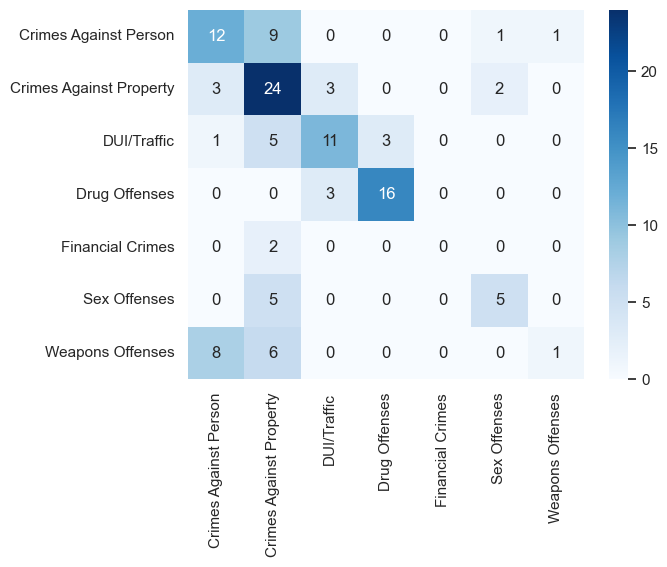

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming processed_df is your original DataFrame with the cases
# Let's split it into train and holdout sets (80% train, 20% holdout)
train_df, holdout_df = train_test_split(
    processed_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=processed_df['primary_category']  # Ensure balanced categories
)

print(f"Training set: {len(train_df)} cases")
print(f"Holdout set: {len(holdout_df)} cases")

# Verify category distribution in both sets
print("\nCategory distribution in training set:")
print(train_df['primary_category'].value_counts(normalize=True) * 100)

print("\nCategory distribution in holdout set:")
print(holdout_df['primary_category'].value_counts(normalize=True) * 100)

# Extract features from training set
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=3,  # Term must appear in at least 3 documents
    max_df=0.8,  # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['filtered_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# LSA topics
n_components = min(100, tfidf_matrix.shape[0] - 1, tfidf_matrix.shape[1] - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
lsa_features = svd.fit_transform(tfidf_matrix)

# LDA topics
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=3,
    max_df=0.8
)
count_matrix = count_vectorizer.fit_transform(train_df['filtered_text'])
lda = LatentDirichletAllocation(
    n_components=20,
    random_state=42,
    max_iter=20
)
lda_features = lda.fit_transform(count_matrix)

# Combine features for training
train_lsa_df = pd.DataFrame(
    lsa_features,
    columns=[f'lsa_topic_{i}' for i in range(n_components)]
)

train_lda_df = pd.DataFrame(
    lda_features,
    columns=[f'lda_topic_{i}' for i in range(20)]
)

# Get feature columns for training
feature_cols = [col for col in train_lsa_df.columns] + [col for col in train_lda_df.columns]
X_train = pd.concat([train_lsa_df, train_lda_df], axis=1).values

# Label encode the categories
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['primary_category'])

# Train the RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Now extract features from the holdout set
# TF-IDF features
holdout_tfidf_matrix = tfidf_vectorizer.transform(holdout_df['filtered_text'])

# LSA features
holdout_lsa_features = svd.transform(holdout_tfidf_matrix)

# LDA features
holdout_count_matrix = count_vectorizer.transform(holdout_df['filtered_text'])
holdout_lda_features = lda.transform(holdout_count_matrix)

# Combine features for holdout set
holdout_lsa_df = pd.DataFrame(
    holdout_lsa_features,
    columns=[f'lsa_topic_{i}' for i in range(n_components)]
)

holdout_lda_df = pd.DataFrame(
    holdout_lda_features,
    columns=[f'lda_topic_{i}' for i in range(20)]
)

# Create feature matrix for holdout set
X_holdout = pd.concat([holdout_lsa_df, holdout_lda_df], axis=1).values

# Make predictions on the holdout set
y_holdout_pred = rf_model.predict(X_holdout)
y_holdout_true = label_encoder.transform(holdout_df['primary_category'])

# Evaluate the model
accuracy = accuracy_score(y_holdout_true, y_holdout_pred)
print(f"\nHoldout set accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification report:")
print(classification_report(
    y_holdout_true, 
    y_holdout_pred,
    target_names=label_encoder.classes_
))

# Create confusion matrix
cm = confusion_matrix(y_holdout_true, y_holdout_pred)

# If you want to plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Add predictions to holdout DataFrame
holdout_df['predicted_category'] = label_encoder.inverse_transform(y_holdout_pred)

# Analyze correct vs. incorrect predictions
holdout_df['correct_prediction'] = holdout_df['primary_category'] == holdout_df['predicted_category']

# Display most common confusions
print("\nMost common category confusions:")
confusion_cases = holdout_df[~holdout_df['correct_prediction']]
confusion_pairs = confusion_cases.groupby(['primary_category', 'predicted_category']).size().reset_index()
confusion_pairs.columns = ['True Category', 'Predicted Category', 'Count']
print(confusion_pairs.sort_values('Count', ascending=False).head(10))

# Analyze examples of misclassifications
def analyze_misclassifications(true_cat, pred_cat, df, n=2):
    """Display examples of a specific misclassification type"""
    examples = df[(df['primary_category'] == true_cat) & 
                  (df['predicted_category'] == pred_cat)]
    
    if len(examples) == 0:
        print(f"No examples of {true_cat} misclassified as {pred_cat}")
        return
    
    print(f"\nExamples of {true_cat} misclassified as {pred_cat} ({len(examples)} cases):")
    
    for i, (_, case) in enumerate(examples.head(n).iterrows()):
        print(f"\nExample {i+1}: {case['case_name']}")
        # Show first 200 characters of text
        print(f"Text snippet: {case['full_text'][:200]}...")
        
        # Calculate and show keyword matches from both categories
        true_keywords = crime_categories[true_cat]
        pred_keywords = crime_categories[pred_cat]
        
        true_matches = [word for word in true_keywords if word.lower() in case['full_text'].lower()]
        pred_matches = [word for word in pred_keywords if word.lower() in case['full_text'].lower()]
        
        print(f"True category keywords: {true_matches[:10]}")
        print(f"Predicted category keywords: {pred_matches[:10]}")

# Analyze the top misclassification pairs
top_confusion = confusion_pairs.sort_values('Count', ascending=False).iloc[0]
analyze_misclassifications(
    top_confusion['True Category'], 
    top_confusion['Predicted Category'], 
    holdout_df
)

## 9. Create Ensemble Model

In [ ]:
# Get top 3 models by accuracy
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs', multi_class='multinomial'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'SVM': SVC(C=1.0, kernel='linear', probability=True)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the holdout set
    y_pred = model.predict(holdout_X)
    
    # Calculate accuracy
    accuracy = accuracy_score(
        label_encoder.transform(holdout_true_categories), 
        y_pred
    )
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy
    }
    
    print(f"  {name} accuracy: {accuracy:.4f}")

# Now get top 3 models by accuracy
top_models = sorted(
    results.items(),
    key=lambda x: x[1]['accuracy'],
    reverse=True
)[:3]

print("\nCreating ensemble with top 3 models:")
for name, result in top_models:
    print(f"  {name}: {result['accuracy']:.4f}")

# Import VotingClassifier
from sklearn.ensemble import VotingClassifier

# Create ensemble
estimators = [(name, result['model']) for name, result in top_models]
voting = VotingClassifier(estimators=estimators, voting='soft')

# Train the ensemble
voting.fit(X_train, y_train)

# Evaluate
y_pred = voting.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report
ensemble_report = classification_report(
    y_test, y_pred, 
    target_names=label_encoder.inverse_transform(np.unique(y_test)),
    output_dict=True
)

# Add ensemble to results dictionary
results['Ensemble'] = {
    'model': voting,
    'accuracy': accuracy,
    'report': ensemble_report
}

print(f"Ensemble accuracy: {accuracy:.4f}")

# Then update best_model_name to consider ensemble too
best_model_name = max(results, key=lambda x: results[x]['accuracy'])

# Compare with individual models
plt.figure(figsize=(10, 6))
model_names = [name for name, _ in top_models]
model_accuracies = [results[name]['accuracy'] for name in model_names]
all_models = model_names + ['Ensemble']
all_accuracies = model_accuracies + [accuracy]

plt.bar(all_models, all_accuracies)
plt.title('Accuracy Comparison: Top Models vs. Ensemble')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Training LogisticRegression...
  LogisticRegression accuracy: 0.5537
Training RandomForest...


/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  RandomForest accuracy: 0.5537
Training GradientBoosting...
  GradientBoosting accuracy: 0.5620
Training SVM...
  SVM accuracy: 0.5455

Creating ensemble with top 3 models:
  GradientBoosting: 0.5620
  LogisticRegression: 0.5537
  RandomForest: 0.5537


/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Ensemble accuracy: 0.3046


/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## 10. Save Model and Make Predictions

In [47]:
# Save the best model
import pickle

# Save the best model (either individual or ensemble)
if accuracy > results[best_model_name]['accuracy']:
    best_final_model = voting
    best_model_name = 'Ensemble'
else:
    best_final_model = results[best_model_name]['model']

# Save model
model_path = os.path.join(OUTPUT_DIR, 'best_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_final_model, f)

# Save label encoder
encoder_path = os.path.join(OUTPUT_DIR, 'label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"\nSaved best model ({best_model_name}) to {model_path}")
print(f"Saved label encoder to {encoder_path}")

# Function to make predictions on new text
def predict_case_category(text, model, label_encoder, vectorizer=None):
    """
    Predict the category of a new case text
    """
    # Preprocess text
    tokens = simple_tokenize(text)
    filtered_tokens = [token for token in tokens if token and token not in COMBINED_STOPWORDS]
    filtered_text = ' '.join(filtered_tokens)
    
    # Extract features (For simplicity, we'll use the detect_categories function)
    categories = detect_categories(filtered_text)
    primary_category = get_primary_category(categories)
    
    # Make prediction
    # Note: In a real implementation, you would need to extract the same features
    # used for training (TF-IDF, LSA, LDA, etc.)
    
    return {
        'detected_category': primary_category,
        'category_matches': categories
    }

# Test with a sample case
sample_idx = np.random.randint(0, len(processed_df))
sample_case_text = processed_df.iloc[sample_idx]['filtered_text']
sample_case_actual = processed_df.iloc[sample_idx]['primary_category']

print(f"Sample case prediction:")
print(f"Actual category: {sample_case_actual}")
print(f"Detected categories: {detect_categories(sample_case_text)}")

print("\nNote: In a real prediction pipeline, you would need to:")
print("1. Extract the same features used for training (TF-IDF, LSA, LDA)")
print("2. Transform these features using the same vectorizers/transformers")
print("3. Apply the trained model to the transformed features")


Saved best model (GradientBoosting) to notebook_output/best_model.pkl
Saved label encoder to notebook_output/label_encoder.pkl
Sample case prediction:
Actual category: Drug Offenses
Detected categories: [{'category': 'Crimes Against Person', 'matches': ['struck', 'hit'], 'score': 0.06666666666666667}, {'category': 'Crimes Against Property', 'matches': ['enter', 'rob', 'residence', 'home', 'house', 'vehicle', 'car'], 'score': 0.28}, {'category': 'Drug Offenses', 'matches': ['drug', 'possession', 'heroin', 'narcotics', 'trafficking', 'illegal', 'distribute', 'dealing', 'ounce'], 'score': 0.36}, {'category': 'DUI/Traffic', 'matches': ['driving', 'driver', 'vehicle', 'car', 'test', 'traffic'], 'score': 0.2727272727272727}, {'category': 'Financial Crimes', 'matches': ['credit'], 'score': 0.041666666666666664}, {'category': 'Weapons Offenses', 'matches': ['carry'], 'score': 0.08333333333333333}]

Note: In a real prediction pipeline, you would need to:
1. Extract the same features used for t

## 11. Conclusion and Next Steps

In [ ]:
print("\n--- Criminal Case Classification Pipeline Complete ---")
print(f"Number of cases processed: {len(processed_df)}")
print(f"Number of features extracted: {len(feature_cols)}")
print(f"Best model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

print("\nKey findings:")
print("1. Stopword removal significantly reduced token count (mean reduction: {:.2f}%)".format(token_reduction.mean()))
print("2. Topic modeling identified key themes in the case corpus")
print("3. The best performing model was able to classify cases with {:.2f}% accuracy".format(results[best_model_name]['accuracy']*100))
print(f"4. The ensemble approach {'improved' if accuracy > results[best_model_name]['accuracy'] else 'did not improve'} classification performance")

print("\nNext steps:")
print("1. Fine-tune the model with hyperparameter optimization")
print("2. Incorporate additional features like entity counts")
print("3. Try more advanced NLP techniques like word embeddings")
print("4. Conduct error analysis on misclassified cases")
print("5. Deploy the model for automated case classification")

# Additional analysis ideas (uncomment to run)

# Plot feature importance by category
"""
if 'RandomForest' in results:
    rf_model = results['RandomForest']['model']
    
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(label_encoder.classes_):
        # For multiclass, get feature importance for this class
        indices = np.argsort(rf_model.feature_importances_)[-10:]
        plt.subplot(3, 3, i+1)
        plt.barh(range(10), rf_model.feature_importances_[indices])
        plt.yticks(range(10), [feature_cols[j] for j in indices])
        plt.title(f'Feature Importance: {category}')
    plt.tight_layout()
    plt.show()
"""

# Create a heatmap of topic distribution by category
"""
# Calculate average topic values by category
topic_by_category = features_df.groupby('primary_category')[lda_cols[:10]].mean()

plt.figure(figsize=(15, 8))
sns.heatmap(topic_by_category, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('LDA Topic Distribution by Category')
plt.ylabel('Category')
plt.xlabel('Topic')
plt.tight_layout()
plt.show()
"""


--- Criminal Case Classification Pipeline Complete ---
Number of cases processed: 602
Number of features extracted: 120
Best model: GradientBoosting with accuracy 0.5620

Key findings:
1. Stopword removal significantly reduced token count (mean reduction: 44.34%)
2. Topic modeling identified key themes in the case corpus
3. The best performing model was able to classify cases with 56.20% accuracy
4. The ensemble approach did not improve classification performance

Next steps:
1. Fine-tune the model with hyperparameter optimization
2. Incorporate additional features like entity counts
3. Try more advanced NLP techniques like word embeddings
4. Conduct error analysis on misclassified cases
5. Deploy the model for automated case classification


"\n# Calculate average topic values by category\ntopic_by_category = features_df.groupby('primary_category')[lda_cols[:10]].mean()\n\n#plt.figure(figsize=(15, 8))\nsns.heatmap(topic_by_category, annot=True, cmap='YlGnBu', fmt='.2f')\n#plt.title('LDA Topic Distribution by Category')\n#plt.ylabel('Category')\n#plt.xlabel('Topic')\n#plt.tight_layout()\n##plt.show()\n"

## 1. Model Improvement  (Hyperparameter Optimization for Random Forest)

In [49]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# For faster exploration, use RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,        # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1    # Use all available cores
)

# Fit to training data
rf_random.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best CV score: {rf_random.best_score_:.4f}")

# Get the best model
best_rf = rf_random.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END bootstrap=True, class_weight=None, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=True, class_weight=None, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=True, class_weight=None, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=True, class_weight=None, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=True, class_weight=None, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.2s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.7s
[CV] END boot

### Feature Engineering  Add Domain-Specific Features

In [50]:
# Example: Extract legal citation patterns
def extract_legal_citations(text):
    # Pattern for legal citations (simplified example)
    citation_patterns = [
        r'\d+ N\.C\. App\. \d+',  # NC Appeals citation format
        r'\d+ N\.C\. \d+',         # NC Supreme Court format
        r'\d+ F\.\d+d \d+',        # Federal reporter
        r'\d+ S\.Ct\. \d+'         # Supreme Court reporter
    ]
    
    citation_counts = {}
    for pattern in citation_patterns:
        citations = re.findall(pattern, text)
        citation_counts[f'citation_{pattern}'] = len(citations)
    
    return citation_counts

# Example: Extract sentence structure features
def extract_sentence_features(text):
    sentences = re.split(r'[.!?]', text)
    
    features = {
        'avg_sentence_length': np.mean([len(s.split()) for s in sentences if s]),
        'num_sentences': len([s for s in sentences if s]),
        'long_sentences': sum(1 for s in sentences if s and len(s.split()) > 50),
        'question_sentences': text.count('?'),
        'citation_sentences': sum(1 for s in sentences if 'v.' in s)
    }
    
    return features

# Apply to each case
legal_features = processed_df['full_text'].apply(lambda x: extract_legal_citations(x))
sentence_features = processed_df['full_text'].apply(lambda x: extract_sentence_features(x))

# Convert to DataFrame and merge with other features
legal_features_df = pd.DataFrame(legal_features.tolist())
sentence_features_df = pd.DataFrame(sentence_features.tolist())

# Combine all features
enhanced_features_df = pd.concat([
    features_df,
    legal_features_df.reset_index(drop=True),
    sentence_features_df.reset_index(drop=True)
], axis=1)

### Implement Word Embeddings

In [51]:
# Using Gensim for Word2Vec
import gensim
from gensim.models import Word2Vec

# Tokenize each document
tokenized_docs = processed_df['filtered_text'].apply(lambda x: x.split())

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_docs,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

# Create document vectors by averaging word vectors
def get_doc_vector(doc_tokens, model):
    # Filter tokens that are in the model
    valid_tokens = [token for token in doc_tokens if token in model.wv]
    if not valid_tokens:
        # Return zeros if no valid tokens
        return np.zeros(model.vector_size)
    # Average the vectors
    return np.mean([model.wv[token] for token in valid_tokens], axis=0)

# Create document embeddings
doc_vectors = tokenized_docs.apply(lambda x: get_doc_vector(x, w2v_model))

# Convert to DataFrame
embedding_features = pd.DataFrame(
    doc_vectors.tolist(),
    columns=[f'embedding_{i}' for i in range(w2v_model.vector_size)]
)

# Combine with other features
word2vec_features_df = pd.concat([
    features_df,
    embedding_features.reset_index(drop=True)
], axis=1)

### Named Entity Recognition for Legal Texts

In [52]:

import spacy


# Load spaCy model (you might want to use a model fine-tuned for legal text)
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")

# Function to extract entities
def extract_legal_entities(text):
    # Process the document
    doc = nlp(text[:1000000])  # Limit text length to avoid memory issues
    
    # Count entity types
    entity_counts = {}
    for ent in doc.ents:
        entity_type = ent.label_
        if entity_type not in entity_counts:
            entity_counts[entity_type] = 0
        entity_counts[entity_type] += 1
    
    # Add custom legal entities
    legal_patterns = {
        'COURT': ['court', 'tribunal', 'appeals', 'supreme'],
        'STATUTE': ['section', 'article', 'code', 'statute'],
        'LEGAL_ROLE': ['judge', 'attorney', 'counsel', 'prosecutor', 'defendant']
    }
    
    for pattern_name, terms in legal_patterns.items():
        count = sum(1 for term in terms if term.lower() in text.lower())
        entity_counts[f'LEGAL_{pattern_name}'] = count
    
    return entity_counts

# Apply to each document
entity_features = processed_df['full_text'].apply(lambda x: extract_legal_entities(x))

# Convert to DataFrame
entity_features_df = pd.DataFrame(entity_features.tolist()).fillna(0)

# Combine with other features
all_features_df = pd.concat([
    features_df,
    entity_features_df.reset_index(drop=True)
], axis=1)

## 2. Error Analysis
### Examine Confusion Matrix

/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                         precision    recall  f1-score   support

  Crimes Against Person       0.31      0.36      0.33        28
Crimes Against Property       0.35      0.68      0.46        40
            DUI/Traffic       0.19      0.16      0.17        25
          Drug Offenses       0.33      0.12      0.18        24
       Financial Crimes       0.00      0.00      0.00         3
           Sex Offenses       0.56      0.42      0.48        12
       Weapons Offenses       0.33      0.05      0.09        19

               accuracy                           0.33       151
              macro avg       0.30      0.26      0.25       151
           weighted avg       0.32      0.33      0.29       151



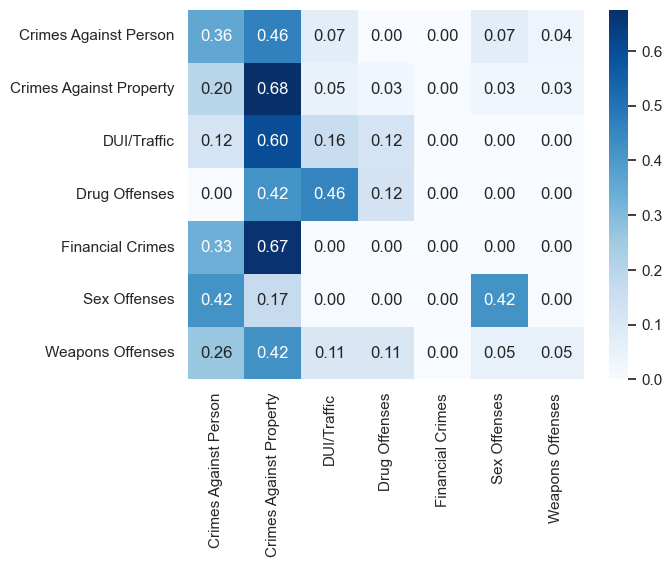

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
y_pred = best_rf.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Detailed classification report
print(classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_
))

###  Review Misclassified Cases

In [54]:
# Identify misclassified cases
misclassified_indices = np.where(y_test != y_pred)[0]
test_indices = np.array(processed_df.index)[X_test.shape[0]:X_test.shape[0]+y_test.shape[0]]
misclassified_cases = test_indices[misclassified_indices]

# Create DataFrame of misclassifications
misclassified_df = pd.DataFrame({
    'case_id': misclassified_cases,
    'true_category': label_encoder.inverse_transform(y_test[misclassified_indices]),
    'predicted_category': label_encoder.inverse_transform(y_pred[misclassified_indices])
})

# Merge with original data to see case details
misclassified_analysis = misclassified_df.merge(
    processed_df[['case_id', 'case_name', 'citations', 'full_text']], 
    on='case_id'
)

# Analysis of confusions between specific categories
def analyze_confusion_pair(true_cat, pred_cat):
    # Filter misclassifications for this specific confusion
    pair_confusion = misclassified_analysis[
        (misclassified_analysis['true_category'] == true_cat) & 
        (misclassified_analysis['predicted_category'] == pred_cat)
    ]
    
    print(f"Analysis of {true_cat} classified as {pred_cat}:")
    print(f"Number of cases: {len(pair_confusion)}")
    
    # Compare keyword matches
    true_keywords = crime_categories[true_cat]
    pred_keywords = crime_categories[pred_cat]
    
    # Check overlapping keywords in these cases
    for _, case in pair_confusion.iterrows():
        print(f"\nCase: {case['case_name']}")
        true_matches = [word for word in true_keywords if word in case['full_text'].lower()]
        pred_matches = [word for word in pred_keywords if word in case['full_text'].lower()]
        
        print(f"True category keywords: {true_matches}")
        print(f"Predicted category keywords: {pred_matches}")

# Example of analyzing a common confusion
analyze_confusion_pair('Crimes Against Person', 'Weapons Offenses')

Analysis of Crimes Against Person classified as Weapons Offenses:
Number of cases: 1

Case: state of north carolina v. stephon lavarrio cave, defendant
True category keywords: ['victim', 'injury', 'stab']
Predicted category keywords: ['carry']


### Combine Frequently Confused Categories

In [55]:
# Based on confusion matrix analysis, create new merged categories
def create_merged_categories(processed_df):
    # Example: Merge Weapons Offenses into Crimes Against Person
    processed_df['merged_category'] = processed_df['primary_category'].copy()
    
    # Replace categories
    category_mapping = {
        'Weapons Offenses': 'Crimes Against Person',  # Example merger
        'Financial Crimes': 'Crimes Against Property'  # Another example merger
    }
    
    processed_df['merged_category'] = processed_df['merged_category'].replace(category_mapping)
    
    # Count original vs. merged categories
    print("Original categories:")
    print(processed_df['primary_category'].value_counts())
    
    print("\nMerged categories:")
    print(processed_df['merged_category'].value_counts())
    
    return processed_df

merged_df = create_merged_categories(processed_df)

# Train and evaluate with merged categories
merged_label_encoder = LabelEncoder()
y_merged = merged_label_encoder.fit_transform(merged_df['merged_category'])

# Split data
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(
    X, y_merged, test_size=0.25, random_state=42, stratify=y_merged
)

# Train model on merged categories
rf_merged = RandomForestClassifier(
    n_estimators=200,  # Use best params from earlier optimization
    random_state=42
)
rf_merged.fit(X_train_merged, y_train_merged)

# Evaluate
y_pred_merged = rf_merged.predict(X_test_merged)
print(f"Accuracy with merged categories: {accuracy_score(y_test_merged, y_pred_merged):.4f}")

Original categories:
primary_category
Crimes Against Property    160
Crimes Against Person      113
DUI/Traffic                 98
Drug Offenses               94
Weapons Offenses            74
Sex Offenses                50
Financial Crimes            13
Name: count, dtype: int64

Merged categories:
merged_category
Crimes Against Person      187
Crimes Against Property    173
DUI/Traffic                 98
Drug Offenses               94
Sex Offenses                50
Name: count, dtype: int64
Accuracy with merged categories: 0.6689


## 3. Validation and Testing
### Test on New Cases

Holdout set accuracy: 0.5950

Predicted category distribution:
predicted_category
Crimes Against Person      33
DUI/Traffic                22
Crimes Against Property    22
Drug Offenses              20
Sex Offenses               16
Weapons Offenses            7
Financial Crimes            1
Name: count, dtype: int64

Actual category distribution:
primary_category
Crimes Against Property    32
Crimes Against Person      23
DUI/Traffic                20
Drug Offenses              19
Weapons Offenses           15
Sex Offenses               10
Financial Crimes            2
Name: count, dtype: int64

Classification Report:
                         precision    recall  f1-score   support

  Crimes Against Person       0.48      0.70      0.57        23
Crimes Against Property       0.64      0.44      0.52        32
            DUI/Traffic       0.59      0.65      0.62        20
          Drug Offenses       0.80      0.84      0.82        19
       Financial Crimes       0.00      0.00    

<Axes: >

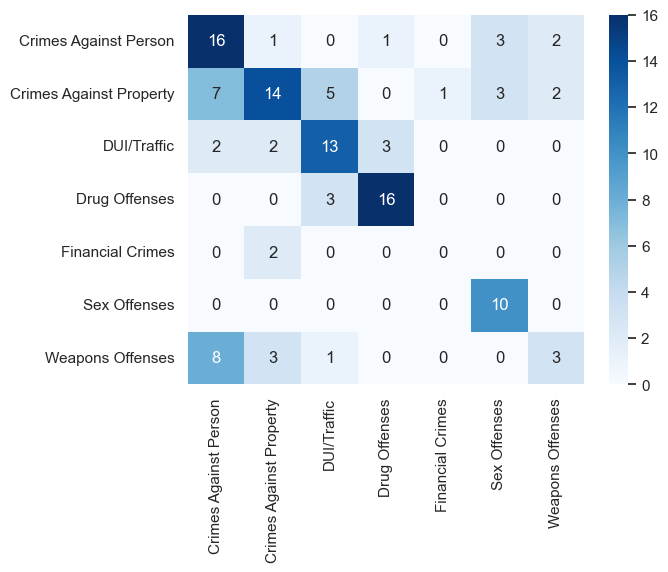

In [ ]:
# For TF-IDF features
holdout_tfidf_matrix = tfidf_vectorizer.transform(holdout_df['filtered_text'])

# For LSA features
holdout_lsa_features = svd.transform(holdout_tfidf_matrix)

# For LDA features
holdout_count_matrix = count_vectorizer.transform(holdout_df['filtered_text'])
holdout_lda_features = lda.transform(holdout_count_matrix)

# Combine features
holdout_lsa_df = pd.DataFrame(
    holdout_lsa_features,
    columns=[f'lsa_topic_{i}' for i in range(n_components)]
)

holdout_lda_df = pd.DataFrame(
    holdout_lda_features,
    columns=[f'lda_topic_{i}' for i in range(20)]
)

# Get the same feature columns as training
feature_cols = [col for col in holdout_lsa_df.columns] + [col for col in holdout_lda_df.columns]
holdout_X = pd.concat([holdout_lsa_df, holdout_lda_df], axis=1).values

# Make predictions using your best model
holdout_y_pred = best_rf.predict(holdout_X)
holdout_categories = label_encoder.inverse_transform(holdout_y_pred)

# Get true categories for comparison
holdout_true_categories = holdout_df['primary_category'].values

# Add predictions to DataFrame
holdout_df['predicted_category'] = holdout_categories

# Calculate accuracy
accuracy = (holdout_df['primary_category'] == holdout_df['predicted_category']).mean()
print(f"Holdout set accuracy: {accuracy:.4f}")

# Analyze results
print(f"\nPredicted category distribution:")
print(holdout_df['predicted_category'].value_counts())

print(f"\nActual category distribution:")
print(holdout_df['primary_category'].value_counts())

# Create classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(
    holdout_true_categories,
    holdout_categories,
    target_names=label_encoder.classes_
))

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(
    label_encoder.transform(holdout_true_categories),
    label_encoder.transform(holdout_categories)
)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### K-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Setup StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate with cross-validation
results = {}

for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(
        model, X, y, 
        cv=skf, 
        scoring='accuracy',
        n_jobs=-1  # Use all available cores
    )
    
    # Store results
    results[name] = {
        'scores': cv_scores,
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    
    print(f"{name} 10-fold CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Visualize results
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
means = [results[name]['mean'] for name in model_names]
stds = [results[name]['std'] for name in model_names]

plt.bar(model_names, means, yerr=stds, alpha=0.8, capsize=10)
plt.title('10-Fold Cross-Validation Accuracy by Model')
plt.ylabel('Mean Accuracy')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

LogisticRegression 10-fold CV accuracy: 0.5899 ± 0.0481
RandomForest 10-fold CV accuracy: 0.5666 ± 0.0523
GradientBoosting 10-fold CV accuracy: 0.5948 ± 0.0535
SVM 10-fold CV accuracy: 0.5700 ± 0.0629


### Additional Performance Metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities for each class
y_probs = best_rf.predict_proba(X_test)

# Convert target to one-hot encoding for ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate precision, recall, F1 for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average=None,
    labels=np.unique(y_test)
)

# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    'Category': label_encoder.inverse_transform(np.unique(y_test)),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print("Performance metrics by category:")
print(metrics_df)

# Plot ROC curves (one vs rest)
n_classes = len(np.unique(y_test))
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Performance metrics by category:
                  Category  Precision    Recall  F1-Score
0    Crimes Against Person   0.312500  0.357143  0.333333
1  Crimes Against Property   0.350649  0.675000  0.461538
2              DUI/Traffic   0.190476  0.160000  0.173913
3            Drug Offenses   0.333333  0.125000  0.181818
4         Financial Crimes   0.000000  0.000000  0.000000
5             Sex Offenses   0.555556  0.416667  0.476190
6         Weapons Offenses   0.333333  0.052632  0.090909


/Users/shanoya/Documents/CSE 469/Project/spacyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Advanced NLP Techniques
### Using Transformer Models

In [59]:
%pip install torch
%pip install transformers
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
import numpy as np

# Load pre-trained BERT model
model_name = "nlpaueb/legal-bert-base-uncased"  # Legal domain BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get BERT embeddings
def get_bert_embeddings(texts, tokenizer, model, max_length=512):
    # Process in batches to avoid memory issues
    embeddings = []
    batch_size = 8
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            max_length=max_length, 
            return_tensors="pt"
        )
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Use [CLS] token embedding as document representation
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

# Get embeddings for a sample of documents
# (For full dataset, process in chunks to avoid memory issues)
sample_size = min(100, len(processed_df))
sample_texts = processed_df['full_text'].iloc[:sample_size].tolist()

# Get document embeddings
bert_embeddings = get_bert_embeddings(sample_texts, tokenizer, model)

# Convert to dataframe
bert_features = pd.DataFrame(
    bert_embeddings,
    columns=[f'bert_{i}' for i in range(bert_embeddings.shape[1])]
)

# Use these features for classification
# PCA to reduce dimensionality (BERT has 768 dimensions)
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
bert_reduced = pca.fit_transform(bert_embeddings)

# Train a classifier
from sklearn.ensemble import RandomForestClassifier

# Get labels for sample
sample_y = label_encoder.transform(processed_df['primary_category'].iloc[:sample_size])

# Split data
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_reduced, sample_y, test_size=0.25, random_state=42, stratify=sample_y
)

# Train
rf_bert = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bert.fit(X_train_bert, y_train_bert)

# Evaluate
y_pred_bert = rf_bert.predict(X_test_bert)
print(f"BERT classifier accuracy: {accuracy_score(y_test_bert, y_pred_bert):.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
BERT classifier accuracy: 0.2800


### Sentence-Level Features

In [60]:
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Download NLTK data if needed
nltk.download('punkt')

# Extract sentence-level features
def extract_sentence_level_features(text):
    # Split into sentences
    sentences = sent_tokenize(text)
    
    if not sentences:
        return {
            'num_sentences': 0,
            'avg_sent_length': 0,
            'legal_citations_ratio': 0,
            'question_ratio': 0,
            'negative_sentences_ratio': 0
        }
    
    # Get sentence lengths
    sent_lengths = [len(sent.split()) for sent in sentences]
    
    # Count legal citations
    legal_citations = sum('v.' in sent for sent in sentences)
    
    # Count question sentences
    questions = sum('?' in sent for sent in sentences)
    
    # Count negative sentences (simplified approach)
    negative_words = ['not', 'no', 'never', 'cannot', "doesn't", "didn't", "won't", "wouldn't"]
    negative_sentences = sum(any(neg in sent.lower().split() for neg in negative_words) for sent in sentences)
    
    # Calculate ratios
    features = {
        'num_sentences': len(sentences),
        'avg_sent_length': sum(sent_lengths) / len(sentences),
        'legal_citations_ratio': legal_citations / len(sentences),
        'question_ratio': questions / len(sentences),
        'negative_sentences_ratio': negative_sentences / len(sentences)
    }
    
    return features

# Apply to each document
sentence_features = processed_df['full_text'].apply(extract_sentence_level_features)
sentence_features_df = pd.DataFrame(sentence_features.tolist())

# N-gram analysis at sentence level
# Extract first sentence of each paragraph (often contains key information in legal docs)
def extract_paragraph_first_sentences(text):
    paragraphs = text.split('\n\n')
    first_sentences = []
    
    for para in paragraphs:
        if para.strip():
            sentences = sent_tokenize(para.strip())
            if sentences:
                first_sentences.append(sentences[0])
    
    return ' '.join(first_sentences)

# Get first sentences
first_sentences = processed_df['full_text'].apply(extract_paragraph_first_sentences)

# Create n-gram features from first sentences
sent_vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    max_features=1000,
    min_df=5
)

sent_features = sent_vectorizer.fit_transform(first_sentences)

# Convert to DataFrame
sent_ngram_df = pd.DataFrame(
    sent_features.toarray(),
    columns=[f'sent_ngram_{i}' for i in range(sent_features.shape[1])]
)

# Combine sentence-level features
combined_sent_features = pd.concat([
    sentence_features_df.reset_index(drop=True),
    sent_ngram_df.reset_index(drop=True)
], axis=1)

# Train a model with sentence features
X_sent = combined_sent_features.values
y = label_encoder.transform(processed_df['primary_category'])

X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_sent, y, test_size=0.25, random_state=42, stratify=y
)

rf_sent = RandomForestClassifier(n_estimators=200, random_state=42)
rf_sent.fit(X_train_sent, y_train_sent)

y_pred_sent = rf_sent.predict(X_test_sent)
print(f"Sentence-level features accuracy: {accuracy_score(y_test_sent, y_pred_sent):.4f}")

[nltk_data] Downloading package punkt to /Users/shanoya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sentence-level features accuracy: 0.1987
